In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pysrt
import re
import tqdm
import pandas as pd
import logging
from tqdm import tqdm

In [9]:
def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - removes any single character tokens
    Parameters
    ----------
        message : The text message to be preprocessed
    Returns
    -------
        text: The preprocessed text
    """ 
    # Lowercase the twit message
    text = message.lower()
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text
        
# Process for all messages
df = pd.read_csv(r"age.csv",encoding='latin1')
preprocessed = []
for i in range(0,9499):
    message = df['Content'].iloc[i]
    processed_Text = preprocess(message)
    df.loc[i, 'Content'] = processed_Text
    preprocessed.append(str(processed_Text))


In [16]:
df.head(5)

,age,FileName,Content,Unnamed: 3
0,1,0000e06e07496624211632e8e264126c.txt,paranoia is settin'in sumbuddy's gonna get hur...,NaN
1,1,000235a2ba2f48231b7d24e1f08d7878.txt,damn these games kicked my ass today huge wate...,NaN
2,1,000c4b6e2468f7d528876fd1a6dffd4c.txt,it is better to conquer yourself than to win t...,NaN
3,1,001187432d2a247562082cd0000dec40.txt,its hot over here lol aloha everyone heading o...,NaN
4,1,001494c3b74f124a2e3435fff17f376b.txt,he's the lord of all the earth the maker of al...,NaN


In [7]:
df['age'].value_counts()

0    5669
1    2401
2    1045
3     385
Name: age, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(df["age"].values, num_classes=4)

X_train, X_test, y_train, y_test = train_test_split(df['Content'], y, test_size=0.1)


In [10]:
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /home/itadmin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/itadmin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/itadmin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def tokenize_text(text, option):
  '''
  Tokenize the input text as per specified option
    1: Use python split() function
    2: Use regex to extract alphabets plus 's and 't
    3: Use NLTK word_tokenize()
    4: Use NLTK word_tokenize(), remove stop words and apply lemmatization
  '''
  if option == 1:
    return text.split()
  elif option == 2:
    return re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
  elif option == 3:
    return [word for word in word_tokenize(text) if (word.isalpha()==1)]
  elif option == 4:
    words = [word for word in word_tokenize(text) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return lemmatized
  else:
    logging.warn("Please specify option value between 1 and 4")
    return []


In [12]:
from torch import nn
import torch

# Define LSTM Model
class LstmTextClassifier(nn.Module):
  def __init__(self, vocab_size, embed_size, lstm_size, dense_size, output_size, lstm_layers=2, dropout=0.1):
    """
    Initialize the model
    """
    super().__init__()
    self.vocab_size = vocab_size
    self.embed_size = embed_size
    self.lstm_size = lstm_size
    self.dense_size = dense_size
    self.output_size = output_size
    self.lstm_layers = lstm_layers
    self.dropout = dropout

    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
    self.dropout = nn.Dropout(dropout)
    # Insert an additional fully connected when combining with other inputs
    if dense_size == 0:
        self.fc = nn.Linear(lstm_size, output_size)
    else:
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)

    self.softmax = nn.LogSoftmax(dim=1)

  def init_hidden(self, batch_size):
    """
    Initialize the hidden state
    """
    weight = next(self.parameters()).data
    hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
              weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())

    return hidden

  def forward(self, nn_input_text, hidden_state):
    """
    Perform a forward pass of the model on nn_input
    """
    batch_size = nn_input_text.size(0)
    nn_input_text = nn_input_text.long()
    embeds = self.embedding(nn_input_text)
    lstm_out, hidden_state = self.lstm(embeds, hidden_state)
    # Stack up LSTM outputs, apply dropout
    lstm_out = lstm_out[-1,:,:]
    lstm_out = self.dropout(lstm_out)
    # Insert an additional fully connected when combining with other inputs
    if self.dense_size == 0:
        out = self.fc(lstm_out)
    else:
        dense_out = self.fc1(lstm_out)
        out = self.fc2(dense_out)
    # Softmax
    logps = self.softmax(out)

    return logps, hidden_state
      
     
# Define LSTM Tokenizer
def tokenizer_lstm(X, vocab, seq_len, padding):
  '''
  Returns tokenized tensor with left/right padding at the specified sequence length
  '''
  X_tmp = np.zeros((len(X), seq_len), dtype=np.int64)
  for i, text in enumerate(X):
    tokens = tokenize_text(text, 3) 
    token_ids = [vocab[word] for word in tokens]
    end_idx = min(len(token_ids), seq_len)
    if padding == 'right':
      X_tmp[i,:end_idx] = token_ids[:end_idx]
    elif padding == 'left':
      start_idx = max(seq_len - len(token_ids), 0)
      X_tmp[i,start_idx:] = token_ids[:end_idx]

  return torch.tensor(X_tmp, dtype=torch.int64)


In [13]:
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Define a DataSet Class which simply return (x, y) pair
class SimpleDataset(Dataset):
  def __init__(self, x, y):
    self.datalist=[(x[i], y[i]) for i in range(len(y))]
  def __len__(self):
    return len(self.datalist)
  def __getitem__(self,idx):
    return self.datalist[idx]
      
# Data Loader
def create_data_loader(X, y, indices, batch_size, shuffle):
  X_sampled = np.array(X, dtype=object)[indices]
  y_sampled = np.array(y)[indices].astype(int)
  dataset = SimpleDataset(X_sampled, y_sampled)
  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
  return loader


In [14]:
import time
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn.functional as F
from torch.autograd import Variable

def train_cycles(X_all, y_all, vocab, num_samples, model_type, epochs, patience, batch_size, seq_len, lr, clip, log_level):
  result = pd.DataFrame(columns=['Accuracy', 'F1(macro)', 'Total_Time', 'ms/text'], index=num_samples)

  for n in num_samples:
    print("")
    logging.info("############### Start training for %d samples ###############" %n)

    # Stratified sampling
    train_size = n / len(y_all)
    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, test_size=train_size*0.2)
    train_indices, valid_indices = next(sss.split(X_all, y_all))

    # Sample input data
    train_loader = create_data_loader(X_all, y_all, train_indices, batch_size, True)
    valid_loader = create_data_loader(X_all, y_all, valid_indices, batch_size, False)

    if model_type == 'LSTM':
      model = LstmTextClassifier(len(vocab)+1, embed_size=512, lstm_size=1024, dense_size=0, output_size = 4, lstm_layers=4, dropout=0.2)
      model.embedding.weight.data.uniform_(-1, 1)

    start_time = time.perf_counter() # use time.process_time() for CPU time
    acc, f1, model_trained = train_nn_model(model, model_type, train_loader, valid_loader, vocab, epochs, patience, batch_size, seq_len, lr, clip, log_level)
    end_time = time.perf_counter() # use time.process_time() for CPU time
    duration = end_time - start_time
    logging.info("Process Time (sec): {}".format(duration))
    result.loc[n] = (round(acc,4), round(f1,4), duration, duration/n*1000)

  return result, model_trained

# Define metrics
from sklearn.metrics import accuracy_score, f1_score

def metric(y_true, y_pred):
  acc = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred, average='macro')
  return acc, f1


In [15]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")


2023-01-28 22:30:06.995855: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-28 22:30:06.995885: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-28 22:30:06.995909: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (455team3): /proc/driver/nvidia/version does not exist
2023-01-28 22:30:06.996475: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-28 22:30:16.141311: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 93763584 exceeds 10% o

In [17]:
def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']


In [18]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [24]:
num_classes = 4
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = bert_preprocess(i)
x = bert_encoder(x)
x = tf.keras.layers.Dropout(0.1, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='sigmoid', name="output")(x)

model = tf.keras.Model(i, x)


In [25]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_text as text

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)


In [30]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

metrics = tf.metrics.Accuracy()

In [34]:
epochs = 5

init_lr = 3e-5


In [35]:
classifier_model = build_classifier_model()

NameError: name 'tfhub_handle_preprocess' is not defined

In [15]:

n_epochs = 8

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
      balanced_recall,
      balanced_precision,
      balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 5,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(X_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (X_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/40
268/268 [==============================] - 946s 4s/step - loss: 1.0339 - accuracy: 0.5835 - balanced_recall: 0.5141 - balanced_precision: 0.2555 - balanced_f1_score: 0.3387 - val_loss: 0.9810 - val_accuracy: 0.5937 - val_balanced_recall: 0.5012 - val_balanced_precision: 0.2477 - val_balanced_f1_score: 0.3277
Epoch 2/40
268/268 [==============================] - 953s 4s/step - loss: 1.0095 - accuracy: 0.5870 - balanced_recall: 0.5257 - balanced_precision: 0.2690 - balanced_f1_score: 0.3526 - val_loss: 0.9674 - val_accuracy: 0.6011 - val_balanced_recall: 0.5860 - val_balanced_precision: 0.2870 - val_balanced_f1_score: 0.3830
Epoch 3/40
268/268 [==============================] - 960s 4s/step - loss: 0.9949 - accuracy: 0.5915 - balanced_recall: 0.5379 - balanced_precision: 0.2793 - balanced_f1_score: 0.3645 - val_loss: 0.9618 - val_accuracy: 0.5905 - val_balanced_recall: 0.5889 - val_balanced_precision: 0.2810 - val_balanced_f1_score: 0.3789
Epoch 4/40
 39/268 [===>.............

: 

: 

ValueError: x and y must have same first dimension, but have shapes (38,) and (5,)

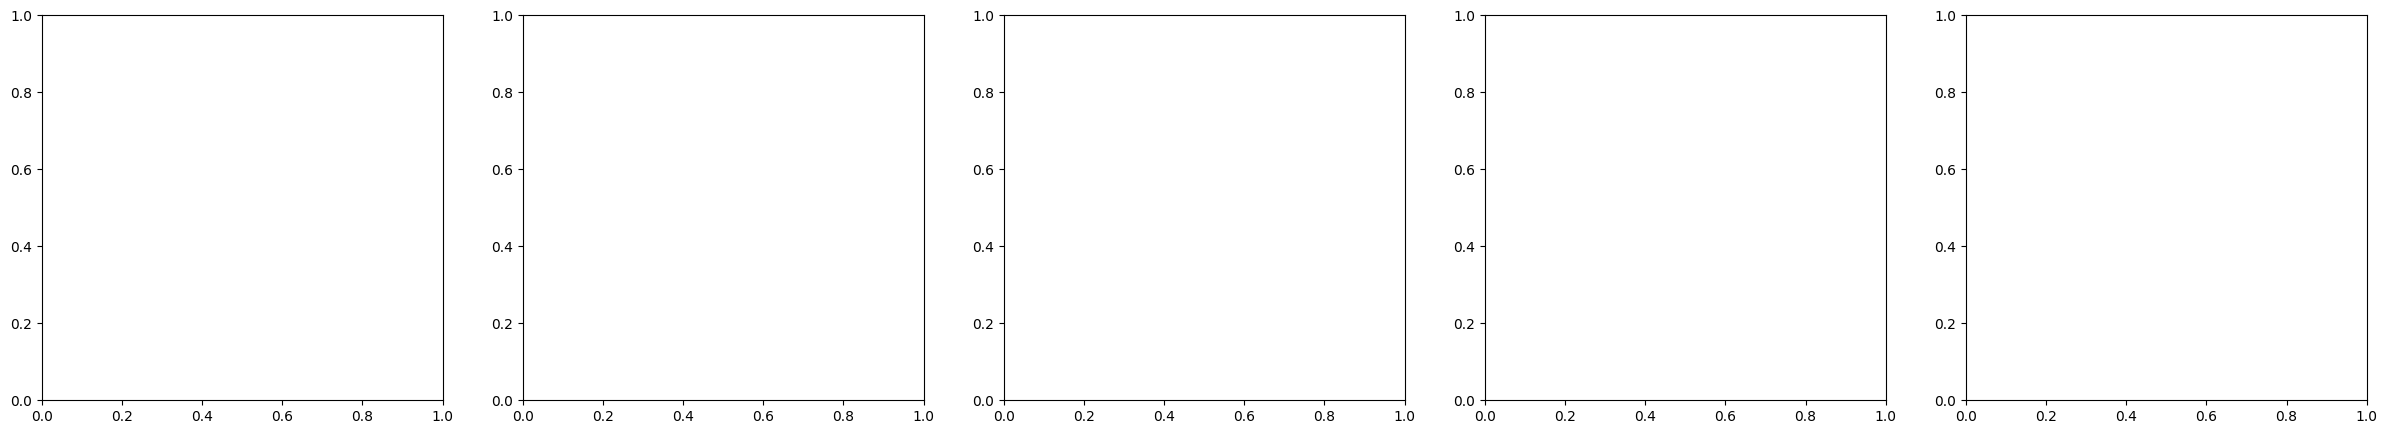

In [14]:

import matplotlib.pyplot as plt

x = list(range(1, n_epochs-1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")


In [15]:
import numpy as np

def predict_class(reviews):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(reviews)]


In [16]:
model.save("~/text_classifier_v1")


2023-01-28 09:46:35.873914: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ~/text_classifier_v1/assets


INFO:tensorflow:Assets written to: ~/text_classifier_v1/assets


In [17]:
import pickle

filename = 'finalized_model_age.sav'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://0ff71077-95d8-4dd0-bff7-e3b263802faf/assets


INFO:tensorflow:Assets written to: ram://0ff71077-95d8-4dd0-bff7-e3b263802faf/assets


In [18]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

ValueError: Unable to restore custom object of type _tf_keras_metric. Please make sure that any custom layers are included in the `custom_objects` arg when calling `load_model()` and make sure that all layers implement `get_config` and `from_config`.

: 

In [3]:
import pickle
import tensorflow as tf
import tensorflow_text as text
# open a file, where you stored the pickled data
file = open("finalized_model_age.sav", 'rb')

# dump information to that file
data = pickle.load(file)

# close the file
file.close()

print('Showing the pickled data:')


ValueError: Unable to restore custom object of type _tf_keras_metric. Please make sure that any custom layers are included in the `custom_objects` arg when calling `load_model()` and make sure that all layers implement `get_config` and `from_config`.